# **Stock Tweets Sentiment Analysis**
#### Alejandro del Rosal Carmona

In [1]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os

#!pip install emoji==1.6.3
#data processing
import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

#!pip install transformers
#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

d:\ProgramFiles\anaconda3\envs\imagen\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 640x480 with 0 Axes>

In [ ]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['negative', 'neutral', 'positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

## **Google Colab Setup (SKIP IF LOCAL)**

In [ ]:
# Mounting the drive [skip this cell if local]
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Checking if the mounting has been succesful
os.path.exists(os.path.join(os.getcwd(), 'drive/MyDrive/MBD'))

True

## **Setting Dataset Location**

In [4]:
# Dataset Directory: BE SURE TO CHANGE THE ROOTDIR OF THE PROJECT
rootdir = os.path.join(os.getcwd(), os.pardir) # 'drive/MyDrive/MBD/ADNE/TEXTO'
dataset1_dir = os.path.join(rootdir, 'data/dataset_1/tweets_labelled_09042020_16072020.csv')
os.path.exists(dataset1_dir)

True

## **Exploring the dataset**

In [5]:
df = pd.read_csv(dataset1_dir, sep=';', on_bad_lines='skip')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5000 non-null   int64 
 1   created_at  5000 non-null   object
 2   text        5000 non-null   object
 3   sentiment   1300 non-null   object
dtypes: int64(1), object(3)
memory usage: 156.4+ KB


Podemos observar que etiquetados solamente hay 1300 tweets de los 5000 que componen el dataset.

In [7]:
df.drop_duplicates(subset='text',inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4843 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          4843 non-null   int64 
 1   created_at  4843 non-null   object
 2   text        4843 non-null   object
 3   sentiment   1284 non-null   object
dtypes: int64(1), object(3)
memory usage: 189.2+ KB


Existían 157 tweets duplicados, que han sido eliminados

In [9]:
df['created_at'] = pd.to_datetime(df['created_at'])

In [10]:
tweets_per_month = df['created_at'].dt.strftime('%Y-%m').value_counts().sort_index().reset_index(name='counts').rename(columns={'index': 'created_at'})

#### Distribución de los tweets por meses

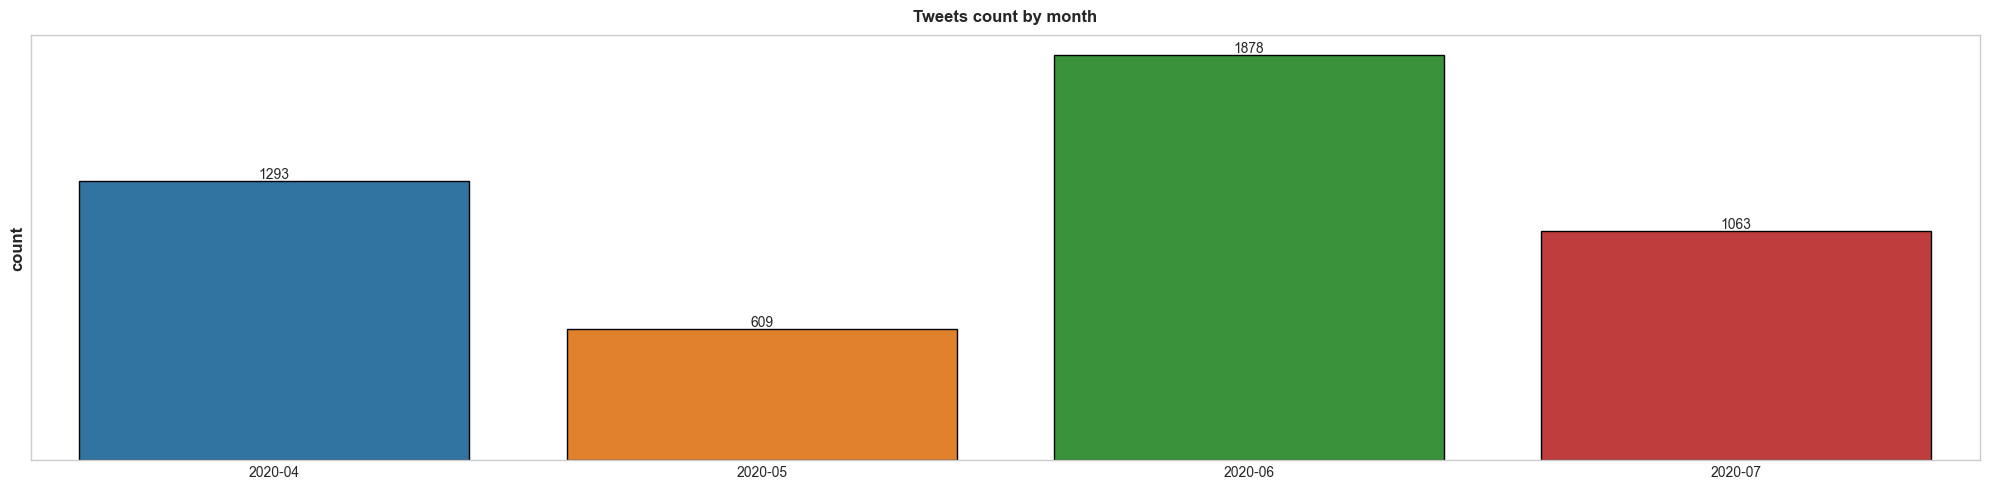

In [11]:
plt.figure(figsize=(20,5))
ax = sns.barplot(data=tweets_per_month, x='created_at', y='counts',edgecolor = 'black', errorbar=('ci', False), hue='created_at')
plt.title('Tweets count by month')
plt.yticks([])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
ax.bar_label(ax.containers[3])
plt.ylabel('count')
plt.xlabel('')
plt.show()

## **Cleaning the dataset**

#### Eliminamos aquellos tweets que no están etiquetados

In [12]:
df = df[df['sentiment'].notna()][['text','sentiment']]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1284 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1284 non-null   object
 1   sentiment  1284 non-null   object
dtypes: object(2)
memory usage: 30.1+ KB


### Limpiamos el texto de los tweets, quitando emojis y carácteres no alfanuméricos

In [14]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [15]:
texts_new = []
for t in df.text:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [16]:
df['text_clean'] = texts_new

#### Distribución de la longitud del texto de los tweets

In [17]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [18]:
df['text_len'] = text_len

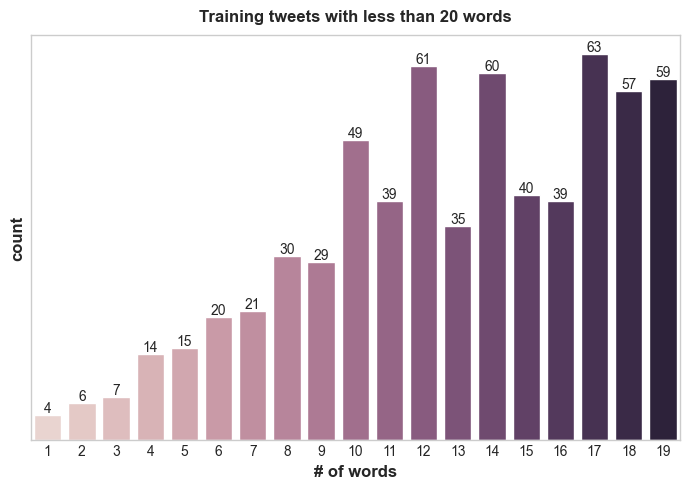

In [28]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<20], hue='text_len', legend=False)
plt.title('Training tweets with less than 20 words')
plt.yticks([])
for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i])
plt.ylabel('count')
plt.xlabel('# of words')
plt.show()

#### Filtramos aquellos tweets con menos de 4 palabras
Se considera que un tweet tan corto no puede realemente contener información sobre el sentimiento de la acción

In [32]:
df = df[df['text_len'] > 4]

### Tokenize with BERT

In [33]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

d:\ProgramFiles\anaconda3\envs\imagen\Lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Aleja\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [38]:
# Analizamos los tweets más largos
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")  

INDEX: 216, TEXT: itox 01s getting slapped nothing on l2 till 2 cents spy spx qqq esf nqf rtyf zbf gcf ndx rut aapl nflx amzn tsla fb msft dia ndx iwm qcom gdx dax bynd twtr gld slv gef baba tlt lyft vxx tvix vix xle xom jpm gs goog dis ibm options
INDEX: 239, TEXT: itox why do insiders own 177 of the shares acb apha cron trtc cann gwph mcig mjna ammj grnh cara cana cgrw cbds clsh codi cvsi digp mdcl mntr mjne mydx nmus ntrr nhle ndev oxis prre rmhb sprwf srna tlry cat tsla gs mgm jnj pfe mrk
INDEX: 306, TEXT: mix pre market action top traded large caps in pre market ba157 nclh935 spy05 ccl455 aapl096 aal029 tsla039 ual169 nkla48 qqq070 tqqq22 rcl485 dal089 nio23 bynd33 msft07 dkng43 iwm085 amzn09 amd079
INDEX: 442, TEXT: spy spx qqq uso uco sco esf nqf rtyf zbf gcf ndx rut aapl nflx amzn shop chwy zm ba tsla fb msft dia iwm qcom gdx dax bynd twtr gld slv gef baba tlt lyft vxx tvix vix xle xom jpm gs goog dis ibm options stocks nasdaq spy
INDEX: 568, TEXT: discord a better more executi

In [39]:
df['token_lens'] = token_lens

In [40]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,text,sentiment,text_clean,text_len,token_lens
455,$SPY $SPX $QQQ $USO $UCO $SCO $ES_F $NQ_F $RTY...,neutral,spy spx qqq uso uco sco esf nqf rtyf zbf gcf n...,50,102
222,$ITOX .01s getting slapped. Nothing on L2 till...,neutral,itox 01s getting slapped nothing on l2 till 2 ...,51,101
245,$ITOX WHY DO INSIDERS OWN 17.7% of the shares?...,neutral,itox why do insiders own 177 of the shares acb...,48,98
762,"$NERV down 72%! Overpanic, OVERSOLD!!!📈🍾💸🛒\n $...",negative,nerv down 72 overpanic oversold aapl amd amrn ...,51,96
315,Mix Pre market action! Top traded large caps i...,positive,mix pre market action top traded large caps in...,31,94
795,$ES - 2nd BIG WIN of the day\n\nShort ES at 31...,positive,es 2nd big win of the day short es at 3167 exi...,48,88
1204,Trump Was Behind On Jobs Goals Before The Viru...,positive,trump was behind on jobs goals before the viru...,56,85
587,"Discord- https://t.co/8fooypATeb a better, m...",neutral,discord a better more executive trading chatro...,44,82
1112,Source of Beijing’s big new #COVID19 outbreak...,neutral,source of beijings big new covid19 outbreak is...,37,80
112,$twtr $msft $amzn $qqq $fb $nflx $xspa $googl ...,neutral,twtr msft amzn qqq fb nflx xspa googl mrna pen...,36,78


Eliminamos aquellos tweets con token_lens > a 80

In [41]:
df = df.iloc[9:]
df.head()

,text,sentiment,text_clean,text_len,token_lens
112,$twtr $msft $amzn $qqq $fb $nflx $xspa $googl ...,neutral,twtr msft amzn qqq fb nflx xspa googl mrna pen...,36,78
1011,CANCEL DEUTSCHE BANK $DB NOW! = #CHOMOBANK\n\n...,negative,cancel deutsche bank db now chomobank real ame...,48,78
377,"#SelfieCompassion: Bill Clinton ""I feel your p...",positive,selfiecompassion bill clinton i feel your pain...,45,76
815,$idex $izea $lk $fb $ibio $dow $spy $tsla $nkl...,positive,idex izea lk fb ibio dow spy tsla nkla dkng aa...,46,76
660,Join the most profitable trading alerts chatro...,neutral,join the most profitable trading alerts chatro...,44,76


In [42]:
df = df.sample(frac=1).reset_index(drop=True)

#### Análisis de la columna objetivo: sentiment

In [43]:
df['sentiment'].value_counts()

sentiment
positive    512
neutral     396
negative    336
Name: count, dtype: int64

In [44]:
df['sentiment'] = df['sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [45]:
df['sentiment'].value_counts()

sentiment
 1    512
 0    396
-1    336
Name: count, dtype: int64

#### Balanceo de clases
Ya que estamos ante un problema de clasificación, debemos tener las clases balanceadas en la medida de lo posible. Para balancearlas vamos a utilizar un RandomOverSampler.

In [80]:
ros = RandomOverSampler()
df_x, df_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['sentiment']).reshape(-1, 1))
df_os = pd.DataFrame(list(zip([x[0] for x in df_x], df_y)), columns = ['text_clean', 'sentiment'])

In [81]:
df_os['sentiment'].value_counts()

sentiment
 1    512
 0    512
-1    512
Name: count, dtype: int64

### Train / Test Split (80/20)

In [85]:
# separte df_os into train and test 80/20
df_train, df_test = train_test_split(df_os, test_size=0.2, random_state=42)

In [86]:
X_test = df_test['text_clean'].values
y_test = df_test['sentiment'].values

### Train / Validation Split (90/10)

In [87]:
# separte df_train into train and validation 90/10
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=42)

In [88]:
X_train = df_train['text_clean'].values
y_train = df_train['sentiment'].values

X_val = df_val['text_clean'].values
y_val = df_val['sentiment'].values

#### One-hot Encoding
Codificamos la columna de sentiment de forma binaria con OneHotEncoding

In [89]:
y_train_le = y_train.copy()
y_valid_le = y_val.copy()
y_test_le = y_test.copy()

In [90]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val = ohe.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [91]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_val.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 1105
VALIDATION DATA: 123
TESTING DATA: 308


## **Training the Models**

## Baseline model: Naive Bayes Classifier
Este modelo nos va a servir como referencia de como de bien (o mal) lo hace un modelo extremadamente sencillo. En principio, modelos más complejos deberían obtener mejores resulatdos que este.

In [92]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [93]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [94]:
nb_clf = MultinomialNB()

In [95]:
nb_clf.fit(X_train_tf, y_train_le)

MultinomialNB()

In [96]:
nb_pred = nb_clf.predict(X_test_tf)

In [97]:
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.60      0.74      0.67        98
     Neutral       0.64      0.62      0.63        98
    Positive       0.66      0.54      0.59       112

    accuracy                           0.63       308
   macro avg       0.63      0.63      0.63       308
weighted avg       0.63      0.63      0.63       308



#### El Naive Bayes Classifier obtiene un accuracy de 63%
Se puede destacar los siguientes detalles:
* El recall de Positive es el más bajo parece ser la clase que más le cuesta acertar
* El recall de Negative es el mejor, en general los resultados son muy mejorables

In [98]:
# Más predicciones negativas que el resto
labels, counts = np.unique(nb_pred, return_counts=True)
for label, count in zip(labels, counts):
    print('Label:', label,'\tCount:',count)

Label: -1 	Count: 121
Label: 0 	Count: 96
Label: 1 	Count: 91


## BERT

In [99]:
MAX_LEN=128

def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [100]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [101]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [102]:
def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [103]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_3[0][0]',             
 el)                         ngAndCrossAttentions(last_   40         'input_4[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                           

In [104]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids, val_attention_masks], y_val), epochs=4, batch_size=32)

Epoch 1/4
35/35 [==============================] - 642s 18s/step - loss: 1.0916 - categorical_accuracy: 0.3964 - val_loss: 0.9738 - val_categorical_accuracy: 0.5691
Epoch 2/4
35/35 [==============================] - 585s 17s/step - loss: 0.9111 - categorical_accuracy: 0.6054 - val_loss: 0.8508 - val_categorical_accuracy: 0.6179
Epoch 3/4
35/35 [==============================] - 591s 17s/step - loss: 0.6873 - categorical_accuracy: 0.7439 - val_loss: 0.7329 - val_categorical_accuracy: 0.7073
Epoch 4/4
35/35 [==============================] - 629s 18s/step - loss: 0.4775 - categorical_accuracy: 0.8335 - val_loss: 0.6653 - val_categorical_accuracy: 0.7317


### Analyzing Results

In [105]:
result_bert = model.predict([test_input_ids, test_attention_masks])

10/10 [==============================] - 48s 4s/step


In [106]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [107]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test, y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.72      0.82      0.77        98
     Neutral       0.78      0.62      0.69        98
    Positive       0.70      0.74      0.72       112

   micro avg       0.73      0.73      0.73       308
   macro avg       0.73      0.73      0.73       308
weighted avg       0.73      0.73      0.73       308
 samples avg       0.73      0.73      0.73       308



#### BERT mejora los resultados pero tampoco de manera drástica. Esto nos hace pensar que los datos tal vez no sean todo lo bueno que se cree.
Cabe destacar las siguientes cosas:
* El accuracy incrementa a 0.73
* El recall de positive ha mejorado considerablemente

## **Adding additional data**
Por ello, hemos buscado otro dataset con tweets de stock. Vamos a unir ambos datasets y a realizar otra vez el entrenamiento de los modelos.

In [108]:
dataset2_dir = os.path.join(rootdir, 'DATA/dataset_2/stock_data.csv')
os.path.exists(dataset2_dir)

True

In [109]:
df1 = df
df2 = pd.read_csv(dataset2_dir)

En este caso los datos añadidos cuentan solo con la columna Text y Sentiment [-1: negativo, 1: positivo]

In [110]:
# Rename columns in df2
df2 = df2.rename(columns={'Text': 'text', 'Sentiment': 'sentiment'})

In [111]:
# Ensure sentiment in df2 is integer type
df2['sentiment'] = df2['sentiment'].astype(int)

In [112]:
df2.drop_duplicates(subset='text',inplace=True)

In [113]:
df2.head(10)

,text,sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
5,PGNX Over 3.04,1
6,AAP - user if so then the current downtrend wi...,-1
7,Monday's relative weakness. NYX WIN TIE TAP IC...,-1
8,GOOG - ower trend line channel test & volume s...,1
9,AAP will watch tomorrow for ONG entry.,1


## **Cleaning the dataset** 

Aplicamos el mismo preprocesado al nuevo dataframe para más tarde unirlos. No realizamos analisis ya que cuenta con columna texto unicamente

In [114]:
texts_new = []
for t in df2.text:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [115]:
df2['text_clean'] = texts_new

In [116]:
text_len = []
for text in df2.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [117]:
df2['text_len'] = text_len

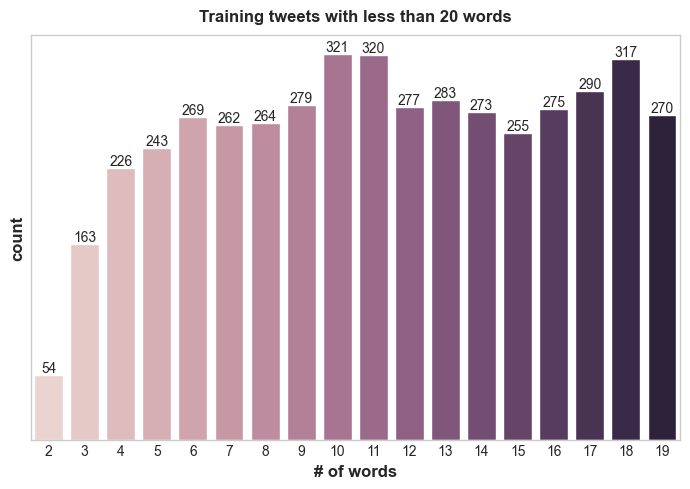

In [125]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df2[df2['text_len']<20], hue='text_len', legend=False)
plt.title('Training tweets with less than 20 words')
plt.yticks([])
for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i])
plt.ylabel('count')
plt.xlabel('# of words')
plt.show()

In [126]:
df2 = df2[df2['text_len'] > 4]

In [127]:
print(f" DF2 SHAPE: {df2.shape}")

 DF2 SHAPE: (5348, 4)


In [128]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [129]:
token_lens = []

for txt in df2['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [130]:
df2['token_lens'] = token_lens

In [131]:
df2 = df2.sort_values(by='token_lens', ascending=False)
df2.head(20)

,text,sentiment,text_clean,text_len,token_lens
1672,A few names with a Bearish Engulfing candle pa...,-1,a few names with a bearish engulfing candle pa...,25,47
4820,"My SHOTS, various strats, AXDX CMCO DGIT D ECY...",-1,my shots various strats axdx cmco dgit d ecyt ...,22,45
3731,Investors into GD SV PA PTM stocks in GDX GDXJ...,1,investors into gd sv pa ptm stocks in gdx gdxj...,26,45
3050,AMN BY AY FCX ABX GOO and GDX GDXJ GDX GGGG GT...,1,amn by ay fcx abx goo and gdx gdxj gdx gggg gt...,26,44
3722,GD SV as mentioned a few days ago GOD stocks o...,1,gd sv as mentioned a few days ago god stocks o...,26,43
3603,seen to outperform peers this week: NF CEG PCY...,1,seen to outperform peers this week nf ceg pcyc...,23,43
3880,DDD IMO The 3D Sector will pay off SH andT CIM...,1,ddd imo the 3d sector will pay off sh andt cim...,28,42
490,"SE SHOT CECO, SM, ACI, DMND, NS, GCY, BBG, EF,...",-1,se shot ceco sm aci dmnd ns gcy bbg ef tm eoc ...,22,42
4487,CIMT already up A gift IMO has much legs opera...,1,cimt already up a gift imo has much legs opera...,27,42
74,Some of the watch list stocks that triggered t...,1,some of the watch list stocks that triggered t...,24,42


In [132]:
df2 = df2.sample(frac=1).reset_index(drop=True)

In [133]:
df2['sentiment'].value_counts()

sentiment
 1    3389
-1    1959
Name: count, dtype: int64

## **Models**

Juntamos ambos datasets

### Baseline Model: Naive Bayes Classifier

In [134]:
df = pd.concat([df1, df2], ignore_index=True)

In [135]:
df = df.sample(frac=1).reset_index(drop=True)

In [136]:
df.head()

,text,sentiment,text_clean,text_len,token_lens
0,RT @CyclesFan: $SPX provided clarity today wit...,-1,rt spx provided clarity today with the close b...,24,28
1,MDSO - ong 27.51. Trailing Stop 41.40 from 1...,1,mdso ong 2751 trailing stop 4140 from 11 prior...,18,31
2,$spy $spx gonna roll out a June PT list tomorr...,0,spy spx gonna roll out a june pt list tomorrow...,11,16
3,Date : 07/07/2020\nTime : 12:42 PM\nTicker : ...,0,date 07072020 time 1242 pm ticker bac exp 0717...,31,53
4,RT @ReformedBroker: Amazon is less than 2% awa...,1,rt amazon is less than 2 away from a record hi...,19,26


In [137]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['sentiment']).reshape(-1, 1));
new_df_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'sentiment']);

In [138]:
X = new_df_os['text_clean'].values
y = new_df_os['sentiment'].values

In [140]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [141]:
X_train, X_valid, y_train, y_valid = train_test_split(X_tr, y_tr, test_size=0.1, stratify=y_tr, random_state=seed)

In [142]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [143]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [144]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 9478
VALIDATION DATA: 1054
TESTING DATA: 1171


In [145]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [146]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [147]:
nb_clf = MultinomialNB()

In [148]:
nb_clf.fit(X_train_tf, y_train_le)

MultinomialNB()

In [149]:
nb_pred = nb_clf.predict(X_test_tf)

In [150]:
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.76      0.82      0.79       390
     Neutral       0.91      1.00      0.95       390
    Positive       0.85      0.70      0.77       391

    accuracy                           0.84      1171
   macro avg       0.84      0.84      0.84      1171
weighted avg       0.84      0.84      0.84      1171



#### Se obtienen mejoras considerables
Se puede destacar los siguientes detalles:
* El accuracy mejora 63% -> 84%
* El recall de negative es el que menos incrementa 74% -> 82%
* Mientras que el recall de positive mejora 54% -> 70%

### BERT

In [152]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [153]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [154]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model_2 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_5[0][0]',             
 el)                         ngAndCrossAttentions(last_   40         'input_6[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                           

In [155]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=32)

Epoch 1/4
297/297 [==============================] - 4677s 16s/step - loss: 0.7026 - categorical_accuracy: 0.6755 - val_loss: 0.4783 - val_categorical_accuracy: 0.7941
Epoch 2/4
297/297 [==============================] - 4420s 15s/step - loss: 0.3645 - categorical_accuracy: 0.8514 - val_loss: 0.3325 - val_categorical_accuracy: 0.8615
Epoch 3/4
297/297 [==============================] - 4262s 14s/step - loss: 0.2272 - categorical_accuracy: 0.9149 - val_loss: 0.3476 - val_categorical_accuracy: 0.8738
Epoch 4/4
297/297 [==============================] - 5118s 17s/step - loss: 0.1280 - categorical_accuracy: 0.9552 - val_loss: 0.3592 - val_categorical_accuracy: 0.8861


In [156]:
result_bert = model.predict([test_input_ids,test_attention_masks])

37/37 [==============================] - 222s 6s/step


In [157]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [158]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.81      0.93      0.87       390
     Neutral       0.97      1.00      0.98       390
    Positive       0.92      0.76      0.83       391

   micro avg       0.89      0.89      0.89      1171
   macro avg       0.90      0.90      0.89      1171
weighted avg       0.90      0.89      0.89      1171
 samples avg       0.89      0.89      0.89      1171



#### De nuevo se obtienen mejoras considerables, parece que lo que faltaban eran datos
Se puede destacar los siguientes detalles:
* El accuracy alcanza el 89%
* El recall de negative y neutral son excelentes
* El recall de positive alcanza mejores resultados 76%